In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#Switching directories for easy access to the data
data = '/Users/alexchoe/Desktop/Capstone/m2py-master/data/all_abstracts_model/'
os.chdir(data)

In [3]:
#Opening contents of Word2Vec model
model = Word2Vec.load("all_abstract_model.model")
vocabulary = list(model.wv.vocab)

In [4]:
data = '/Users/alexchoe/Desktop/Capstone/BETO2020-master/data/carbon/'
os.chdir(data)

In [5]:
#Taking in data as a dataframe for easy pre-processing
df = pd.read_excel('Carbon_SynAntList_Full_Refined.xlsx', skiprows = 1, nrows=2000)
carbon_df = df.rename(columns = {'Unnamed: 0':'index', 0:'word 1', 1:'word 2', 2:'relationship', 'Unnamed: 4':'label'})
carbon_df = carbon_df.fillna(0)
carbon_df = carbon_df[1:]

#finding which words are in the pd but not in vocabulary1
list1 = list(carbon_df['word 1'])
list2 = list(carbon_df['word 2'])
missing = list((set(list1).difference(vocabulary))) + list((set(list2).difference(vocabulary)))

#keeping only the rows in the pd that have words in vocabulary1
carbon_df = carbon_df[~carbon_df['word 1'].isin(missing)]
carbon_df = carbon_df[~carbon_df['word 2'].isin(missing)]

#reseting indices after mask
carbon_df.reset_index(inplace = True)

In [7]:
for i in range(len(carbon_df)):
    carbon_df['word 1'].iloc[i] = model.wv.__getitem__(str(carbon_df['word 1'].iloc[i]))
    carbon_df['word 2'].iloc[i] = model.wv.__getitem__(str(carbon_df['word 2'].iloc[i]))
    
    if carbon_df['relationship'].iloc[i] == 'ant' and carbon_df['label'].iloc[i] == 1:
        carbon_df['relationship'].iloc[i] = 1
    else:
        carbon_df['relationship'].iloc[i] = 0   

/Users/alexchoe/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
carbon_df

,level_0,index,word 1,word 2,relationship,label
0,1,1,"[1.0246488, -5.6508703, -1.4263288, -3.1607409...","[0.3912109, -2.6639938, -0.4191871, -0.3595066...",0,1
1,2,2,"[1.0246488, -5.6508703, -1.4263288, -3.1607409...","[0.67807263, -0.0778522, 3.3564792, -1.8280518...",0,1
2,3,3,"[1.0246488, -5.6508703, -1.4263288, -3.1607409...","[-0.40175724, 0.66337395, -1.5072205, -1.73012...",0,0
3,4,4,"[1.0246488, -5.6508703, -1.4263288, -3.1607409...","[2.6374276, -0.8799803, 1.9580756, -3.1686919,...",0,0
4,7,7,"[1.0246488, -5.6508703, -1.4263288, -3.1607409...","[-1.5558529, 2.824446, -3.416154, -0.963536, 0...",0,0
...,...,...,...,...,...,...
1596,1995,1995,"[-0.2082266, 1.1971192, 1.1562068, -5.095038, ...","[0.38347286, 0.7061271, -0.007815216, -1.64924...",0,0
1597,1996,1996,"[-0.2082266, 1.1971192, 1.1562068, -5.095038, ...","[-2.8429897, 1.9741825, -0.3001447, -5.303599,...",0,0
1598,1997,1997,"[-0.2082266, 1.1971192, 1.1562068, -5.095038, ...","[0.26439202, 0.44663662, -0.2789563, -3.575421...",0,0
1599,1998,1998,"[-0.2082266, 1.1971192, 1.1562068, -5.095038, ...","[-7.4225054, -2.0302646, 0.6465284, -7.604581,...",0,0


In [11]:
carbon_df.to_json('ANT_NN_DATA.json')

In [12]:
carbon_df = pd.read_json('ANT_NN_DATA.json', dtype = np.float32)

In [13]:
#Hyper parameters
num_epochs = 100
batch_size = 50
learning_rate = 0.008

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
X = carbon_df[['word 1', 'word 2']] #Input features used to make predictions
Y = carbon_df[['relationship']] #Target feature to be predicted 
 
x_train, x_test, ant_train, ant_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

x_train.reset_index(inplace = True)
x_test.reset_index(inplace = True)
ant_train.reset_index(inplace = True)
ant_test.reset_index(inplace = True)

x1_train = x_train['word 1']
x2_train = x_train['word 2']
x1_test = x_test['word 1']
x2_test = x_test['word 2']

In [15]:
x_train_array = np.empty((len(x_train),100))
x_train_df = pd.DataFrame(data=x_train_array[0:,:])

x_test_array = np.empty((len(x_test),100))
x_test_df = pd.DataFrame(data=x_test_array[0:,:])

In [16]:
for i in range(len(x_train_df)):
    for u in range(len(x_train['word 2'][i])):
        x_train_df.iloc[i,u] = x_train['word 1'][i][u]
        
for i in range(len(x_train_df)):
    for u in range(len(x_train['word 2'][i])):
        x_train_df.iloc[i,(50+u)] = x_train['word 2'][i][u]

                
for i in range(len(x_test_df)):
    for u in range(len(x_test['word 1'][i])):
        x_test_df.iloc[i,u] = x_test['word 1'][i][u]
        
                
for i in range(len(x_test_df)):
    for u in range(len(x_test['word 2'][i])):
        x_test_df.iloc[i,(50+u)] = x_test['word 2'][i][u]

In [17]:
x_train_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-4.572905,-6.443137,5.794405,-6.471600,6.504431,2.951210,-3.090467,-1.286095,5.204089,2.941126,...,-0.953811,-0.791730,-0.853084,0.103855,0.111677,0.340079,0.946939,0.333773,-0.220313,-0.171673
1,-1.777941,4.843503,0.542043,-3.549473,1.083318,2.146862,0.475878,-0.150475,2.156058,3.089100,...,-0.424291,-0.353807,-0.194475,-0.373754,-0.674903,0.122289,1.001551,-0.616002,0.051963,-0.213525
2,3.025998,0.289955,3.751968,3.400925,-3.493372,-1.015835,3.067935,-6.638695,2.008589,-2.815345,...,-0.641664,-3.914162,4.155166,-1.623855,-0.231471,1.391196,3.749104,1.885215,0.500033,-0.718096
3,-2.260679,-0.688991,-2.192621,4.956737,1.757224,2.145969,2.782162,1.879095,-1.117045,-3.963360,...,0.241486,-0.036381,-0.050983,-0.038339,0.057630,0.076125,0.067552,-0.116768,0.017387,0.067028
4,-4.572905,-6.443137,5.794405,-6.471600,6.504431,2.951210,-3.090467,-1.286095,5.204089,2.941126,...,-7.434420,1.636823,2.959791,3.318134,-0.927886,-0.782501,3.576220,1.751391,1.308552,4.317373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,-1.096448,1.880548,7.234420,-0.867733,-2.772371,-0.380264,-2.024324,-3.206657,1.550386,-0.245448,...,-2.077198,-3.256073,2.812804,-4.099342,-7.988791,1.045651,7.723909,-0.491465,5.692377,6.619974
1276,3.952686,1.531852,-10.797078,5.054812,5.867758,1.440295,5.110829,-5.852190,-1.000157,-6.799130,...,0.122613,0.318446,0.914337,-0.571856,-1.264935,0.416868,2.980009,-0.325881,-0.850117,0.912961
1277,-0.382762,2.394328,1.349133,-0.072012,-2.511072,1.489475,2.405386,-5.643640,0.467026,-2.869704,...,-0.304719,0.014149,0.401125,-2.283455,-0.196228,-0.448581,1.024016,-0.235990,1.140137,1.433193
1278,-4.572905,-6.443137,5.794405,-6.471600,6.504431,2.951210,-3.090467,-1.286095,5.204089,2.941126,...,-3.353548,2.297662,1.898378,1.595865,-3.843940,4.743205,8.232018,3.079020,-3.681024,4.366352


In [19]:
x_train_tensor = torch.tensor(x_train_df.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
ant_train_tensor = torch.tensor(ant_train.values.astype(np.float32))
#nonant_train_tensor = torch.tensor(nonant_train)

#create tensor with features and targets
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, ant_train_tensor)
#create iterable dataset with batches
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

x_test_tensor = torch.tensor(x_test_df.values.astype(np.float32))
ant_test_tensor = torch.tensor(ant_test.values.astype(np.float32))
#nonsyn_test_tensor = torch.tensor(nonsyn_test)

test_tensor = torch.utils.data.TensorDataset(x_test_tensor, ant_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [20]:
#Defining the neural network
class ANT_TEST(nn.Module):

    def __init__(self, in_dims, out_dims):
        super(ANT_TEST, self).__init__()
        
        #embedding layer
        self.embedding_layer = nn.Linear(in_dims, 100)
        
        #hidden layers
        self.hidden_layer = nn.Linear(100, 32)
        self.hidden_layer1 = nn.Linear(32, 16)
        
        #output layer
        self.output_layer = nn.Linear(16,2)
        #self.syn_branch = nn.Sequential(
        #nn.Dropout(p = 0.3),
        #nn.Linear(8,16),
        #nn.Linear(16,32),
        #nn.Linear(32,8),
        #nn.Dropout(p = 0.3)
        #nn.Softplus(),
        #nn.Linear(8,2))
        
    def forward(self,x):
       
        #pass through embedding layer
        out = self.embedding_layer(x)
        
        #pass through hidden layers
        out = self.hidden_layer(out)
        out = self.hidden_layer1(out)
        
        #pass to output layer
        ant_out = self.output_layer(out)
        
        return ant_out

In [26]:
def train_model(model, training_data_set, optimizer):
    train_losses = []
    ant_train_losses = []
    train_epoch_loss = []
    ant_train_epoch_loss = []
    
    ant_losses = []
    train_total = 0
    
    #switch model to training mode
    model.train()
    ant_criterion = nn.MSELoss()
    
    for features, labels in training_data_set:
        
        model.zero_grad() #zero out any gradients from prior loops 
        ant_out = model(features) #gather model predictions for this loop
        
        #calculate error in the predictions
        ant_loss = ant_criterion(ant_out, labels)
        total_loss = ant_loss
        
        #BACKPROPAGATE LIKE A MF
        torch.autograd.backward([ant_loss])
        optimizer.step()
        
        #save loss for this batch
        train_losses.append(total_loss.item())
        train_total+=1
        
        ant_train_losses.append(ant_loss.item())
        
    #calculate and save total error for this epoch of training
    epoch_loss = sum(train_losses)/train_total
    train_epoch_loss.append(epoch_loss)
    
    ant_train_epoch_loss.append(sum(ant_train_losses)/train_total)
    
    #update progress bar
    print(f"Total Epoch Training Loss is: {train_epoch_loss}")
    
    return train_epoch_loss, ant_train_epoch_loss

In [27]:
def eval_model(model, testing_data_set, optimizer):
    #evaluate the model
    model.eval()
    
    ant_criterion = nn.MSELoss()
    #accuracy = #total number of correct predictions divided by the total number of predictions

    #don't update nodes during evaluation b/c not training
    with torch.no_grad():
        test_losses = []
        ant_test_losses = []
        #syn_test_acc_list = []
        
        test_total = 0

        for inputs, labels in testing_data_set:
            inputs = inputs.to(device)
            labels = labels.to(device)

            ant_out = model(inputs)

            # calculate loss per batch of testing data
            ant_test_loss = ant_criterion(ant_out, labels)
            
            test_loss = ant_test_loss
            
            test_losses.append(test_loss.item())
            ant_test_losses.append(ant_test_loss.item())
            test_total += 1 
            #ant_acc = accuracy(ant_out)
            #ant_test_acc_list.append(ant_acc.item())

        test_epoch_loss = sum(test_losses)/test_total
        ant_test_epoch_loss = sum(ant_test_losses)/test_total
        
        #ant_epoch_acc = sum(ant_test_acc_list)/test_total

        print(f"Total Epoch Testing Loss is: {test_epoch_loss}")
        #print(f"Epoch MAPE: Ant = {ant_epoch_acc}")
    
    return test_epoch_loss, ant_test_epoch_loss, #ant_epoch_acc

In [28]:
# Instantiate our beautiful NN model
# takes in 
# predicts antonymy
model = ANT_TEST(in_dims = 100, out_dims = 2).to(device)

#define the optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [29]:
#empty list to hold loss per epoch
train_epoch_losses = []
ant_train_epoch_losses = []

test_epoch_losses = []
ant_test_epoch_losses = []

ant_test_epoch_accuracies = []


for epoch in range(num_epochs):
    
    train_epoch_loss, ant_train_epoch_loss  = train_model(model = model, training_data_set = training_data_set, optimizer = optimizer)
    
    train_epoch_losses.append(train_epoch_loss)
    ant_train_epoch_losses.append(ant_train_epoch_loss)
   
    test_epoch_loss, ant_test_epoch_loss = eval_model(model = model, testing_data_set = testing_data_set, optimizer = optimizer)
    #ant_epoch_acc
    
    test_epoch_losses.append(test_epoch_loss)
    ant_test_epoch_losses.append(ant_test_epoch_loss)
    
    #pce_test_epoch_accuracies.append(pce_epoch_acc)
    #voc_test_epoch_accuracies.append(voc_epoch_acc)
    #jsc_test_epoch_accuracies.append(jsc_epoch_acc)
    #ff_test_epoch_accuracies.append(ff_epoch_acc)

Total Epoch Training Loss is: [238878.81310096153]
Total Epoch Testing Loss is: 105366.56919642857
Total Epoch Training Loss is: [66517.11470853366]
Total Epoch Testing Loss is: 41123.38002232143
Total Epoch Training Loss is: [39732.68825120192]
Total Epoch Testing Loss is: 33680.001674107145
Total Epoch Training Loss is: [32595.525540865383]
Total Epoch Testing Loss is: 28960.910714285714
Total Epoch Training Loss is: [29823.69200721154]
Total Epoch Testing Loss is: 24535.818219866072
Total Epoch Training Loss is: [28232.696927584133]
Total Epoch Testing Loss is: 24217.968191964286
Total Epoch Training Loss is: [26557.24894831731]
Total Epoch Testing Loss is: 22796.87527901786
Total Epoch Training Loss is: [25181.22539813702]
Total Epoch Testing Loss is: 22260.993303571428
Total Epoch Training Loss is: [24478.11564753606]
Total Epoch Testing Loss is: 25885.741629464286
Total Epoch Training Loss is: [23408.28361628606]
Total Epoch Testing Loss is: 22642.818777901786
Total Epoch Trainin

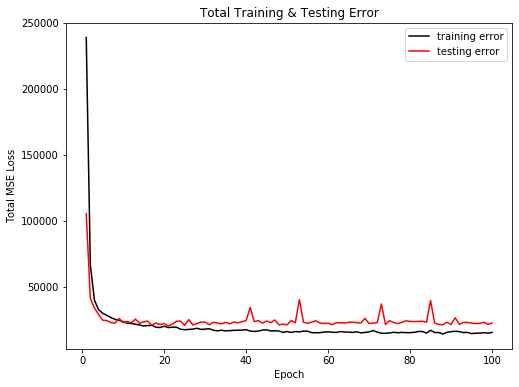

In [30]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Total MSE Loss')
plt.show()

#fig, ax = plt.subplots(figsize = (8,6))
# plt.plot(epochs, train_epoch_accuracy, c = 'k', label = 'training accuracy')
#plt.plot(epochs, pce_test_epoch_accuracies, c = 'k', label = 'pce accuracy')
#plt.plot(epochs, voc_test_epoch_accuracies, c = 'r', label = 'voc accuracy')
#plt.plot(epochs, jsc_test_epoch_accuracies, c = 'g', label = 'jsc accuracy')
#plt.plot(epochs, ff_test_epoch_accuracies, c = 'b', label = 'ff accuracy')
#plt.legend(loc = 'lower right')
#plt.title("Branch Mean Absolute Percent Error")
#ax.set_xlabel('Epoch')
#ax.set_ylabel('MAPE')
#plt.show()